len(test_ff_runs) = 100
Epoch 1/50
1151/1151 [==============================] - 2s 1ms/step - loss: 0.5944 - val_loss: 0.5486
Epoch 2/50
1151/1151 [==============================] - 2s 1ms/step - loss: 0.5470 - val_loss: 0.5458
Epoch 3/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5452 - val_loss: 0.5430
Epoch 4/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5421 - val_loss: 0.5419
Epoch 5/50
1151/1151 [==============================] - 2s 2ms/step - loss: 0.5408 - val_loss: 0.5401
Epoch 6/50
1151/1151 [==============================] - 2s 1ms/step - loss: 0.5401 - val_loss: 0.5396
Epoch 7/50
1151/1151 [==============================] - 2s 1ms/step - loss: 0.5396 - val_loss: 0.5390
Epoch 8/50
1151/1151 [==============================] - 2s 1ms/step - loss: 0.5393 - val_loss: 0.5391
Epoch 9/50
1151/1151 [==============================] - 2s 1ms/step - loss: 0.5391 - val_loss: 0.5387
Epoch 10/50
1151/1151 [==============================] - 2

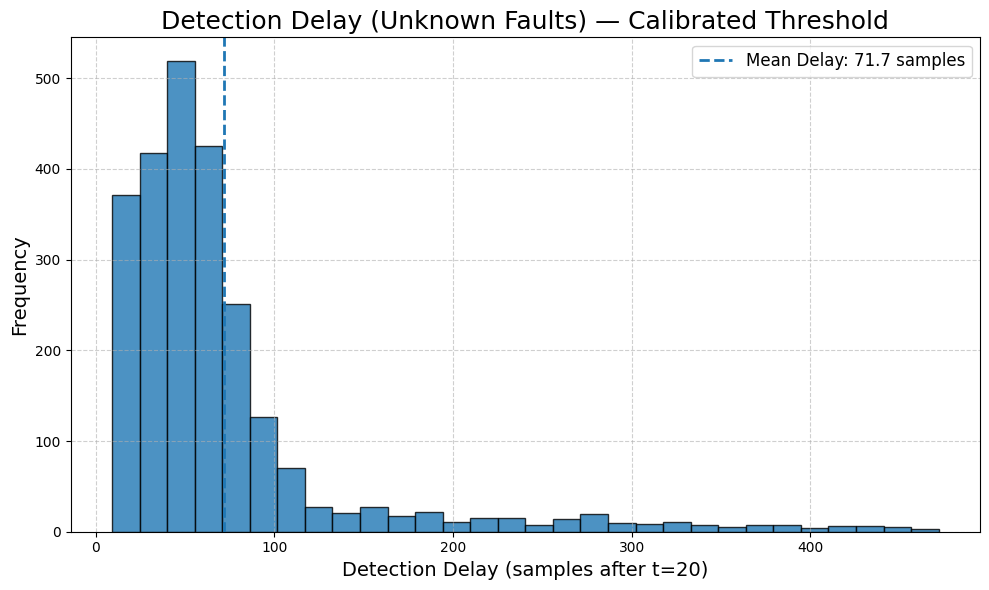

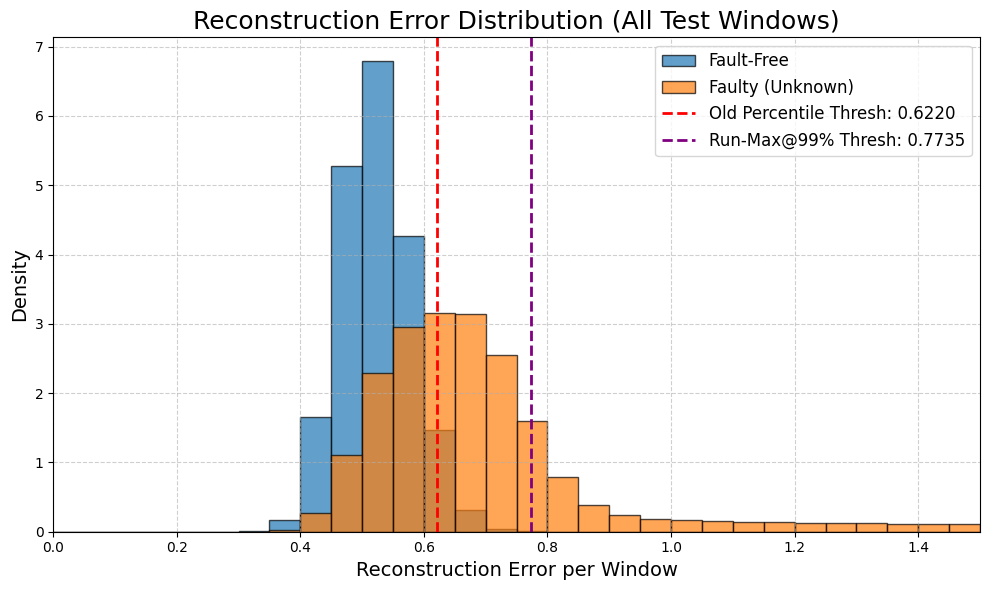

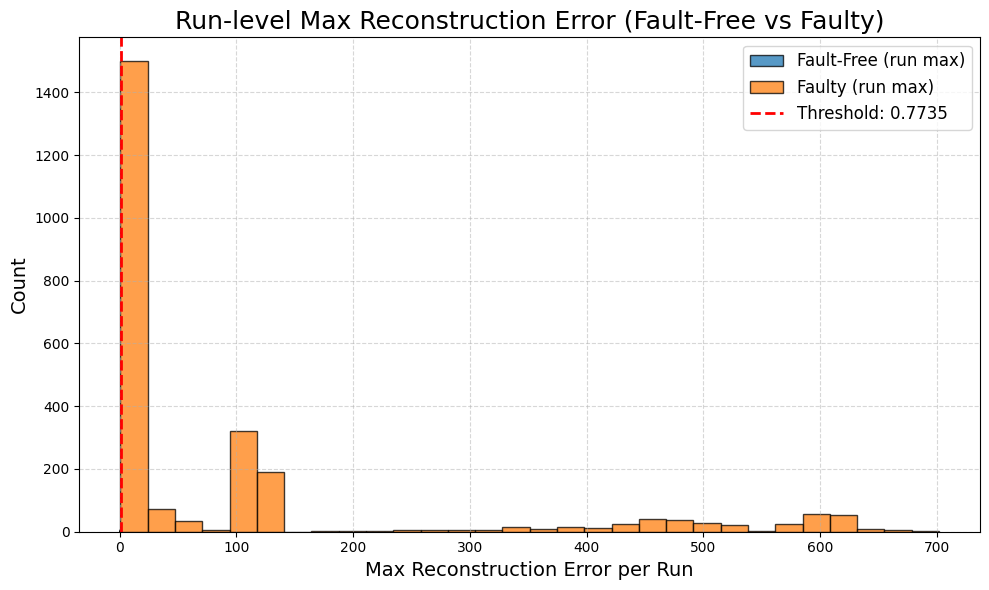

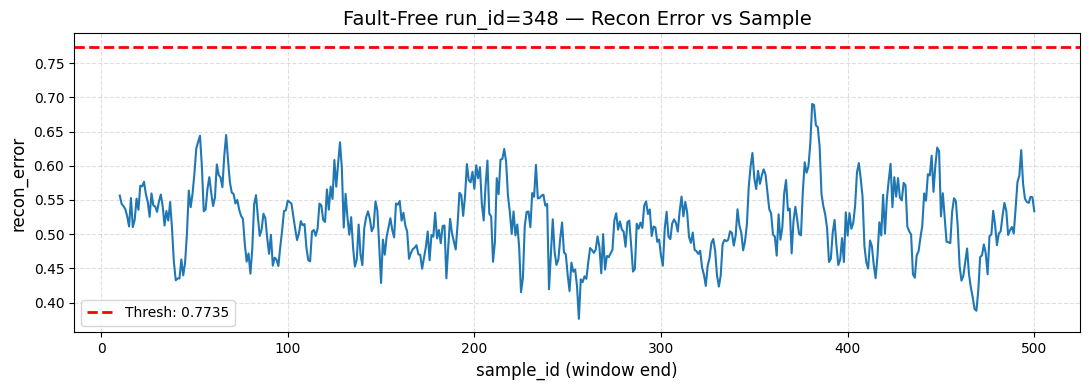

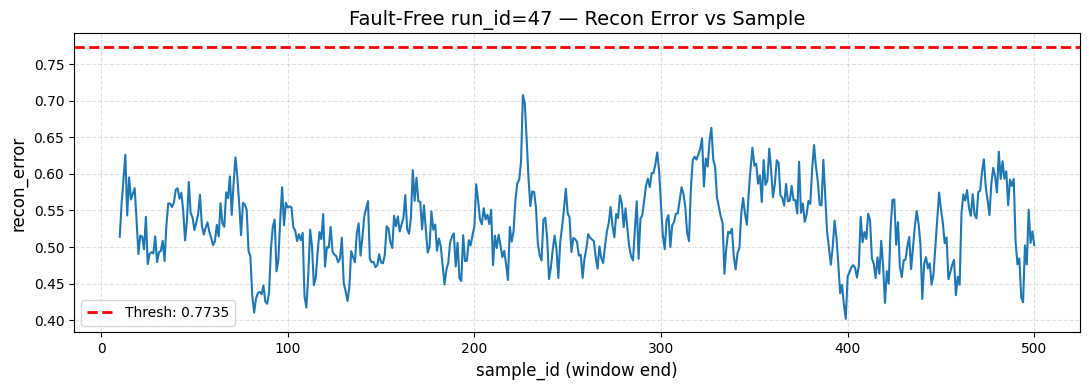

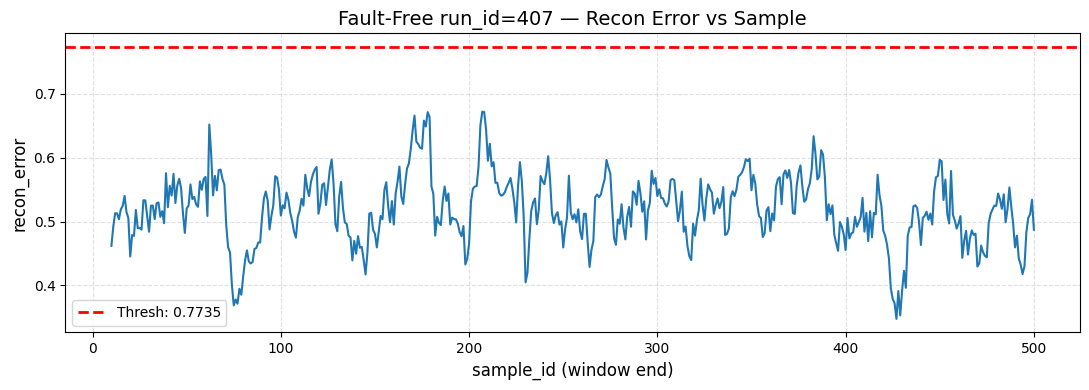

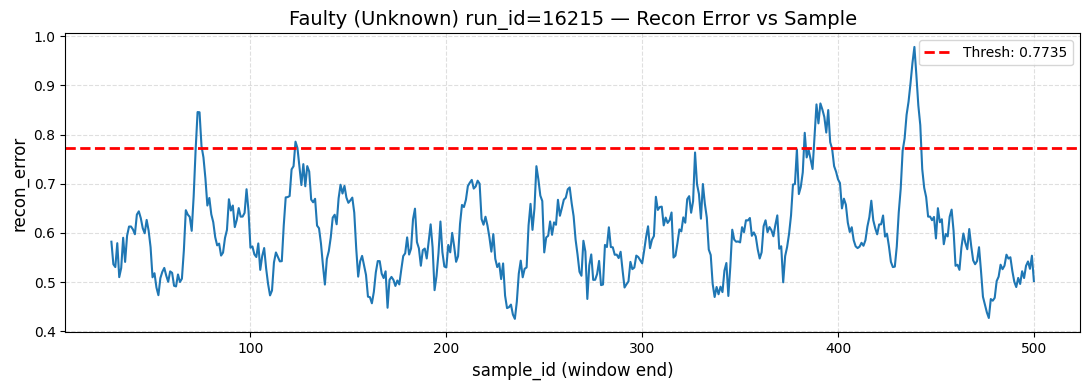

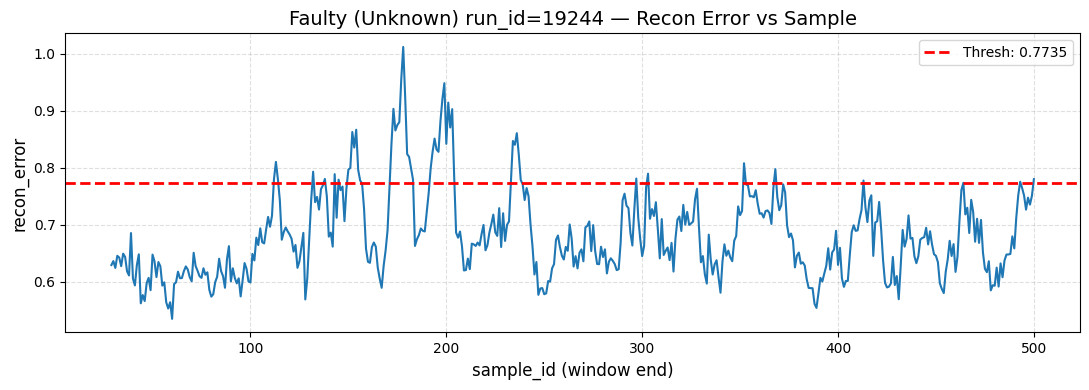

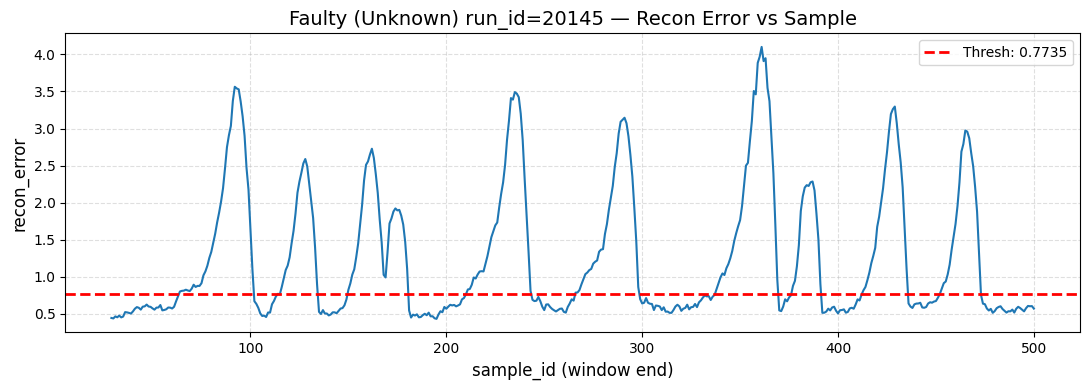


=== Window-level metrics (after stability), using CALIBRATED threshold ===
ROC AUC (window-level, raw recon error): 0.9129
Test Evaluation Time: 31.311 seconds

Classification Report (y_test vs y_pred_stable_cal):
              precision    recall  f1-score   support

           0     0.0767    1.0000    0.1425     49100
           1     1.0000    0.4992    0.6660   1180000

    accuracy                         0.5192   1229100
   macro avg     0.5384    0.7496    0.4042   1229100
weighted avg     0.9631    0.5192    0.6451   1229100



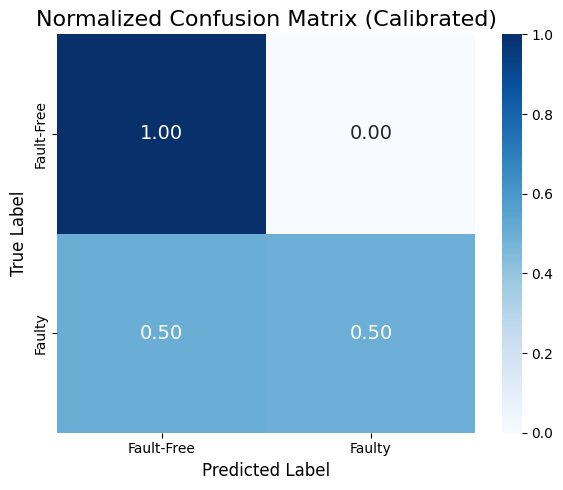


Saved AE model to: c:\Users\custu\My Drive\MSDS 498\early-fault-detection-and-RCA\models\ae_unknown_fault_detector.keras
Saved AE artifact to: c:\Users\custu\My Drive\MSDS 498\early-fault-detection-and-RCA\models\ae_unknown_fault_detector.joblib


In [7]:
import os
import time
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from pathlib import Path

# =========================
# Configuration
# =========================
WINDOW_SIZE = 10
FAULTY_START_SAMPLE = 20

# Old threshold method (kept for reference/plot)
MANUAL_THRESHOLD_PERCENTILE = 95

# NEW: run-level false alarm target on fault-free runs
RUN_LEVEL_FPR_TARGET = 0.40  # 40%

# Stability for AE
CONSECUTIVE_REQUIRED = 2

# Unknown faults to evaluate as "faulty" for ROC / delay
UNKNOWN_FAULTS = [16, 17, 18, 19, 20]

# NEW: Run-level max-error calibration quantile (your request)
# With 100 fault-free runs, 99th percentile ~= allow 1 run to false alarm
RUN_MAX_QUANTILE = 0.99

# Threshold sweep granularity (kept, but no longer required for your chosen method)
N_THRESHOLDS = 80

# =========================
# Paths / Load Data
# =========================
PROJECT_ROOT = Path.cwd().parent  # notebook/ -> repo root
ff_train_path = PROJECT_ROOT / "data" / "TEP_FaultFree_Training_fault_free_training.pkl"
f_train_path  = PROJECT_ROOT / "data" / "TEP_Faulty_Training_faulty_training.pkl"

ff_train = pd.read_pickle(ff_train_path)
f_train  = pd.read_pickle(f_train_path)

# Sensor feature columns
feature_cols = [c for c in ff_train.columns if c not in ["simulationRun", "sample", "faultNumber"]]

# =========================
# Windowing utility
# =========================
def make_windows(df, feature_cols, window_size=10, min_sample=0, return_metadata=False):
    """
    Creates flattened rolling windows per simulationRun.
    Window label/time is aligned to the last sample in the window.

    Returns sequences (n_windows, window_size*n_features)
    If return_metadata=True, also returns run_ids, fault_nums, sample_ids.
    """
    sequences, run_ids, fault_nums, sample_ids = [], [], [], []
    for run_id, group in df.groupby("simulationRun"):
        group = group.sort_values("sample")
        fault_number = int(group["faultNumber"].iloc[0]) if "faultNumber" in group.columns else 0

        group = group[group["sample"] >= min_sample]
        data = group[feature_cols].values
        samples = group["sample"].values

        if len(data) < window_size:
            continue

        for i in range(window_size - 1, len(data)):
            window = data[i - window_size + 1 : i + 1].flatten()
            sequences.append(window)

            if return_metadata:
                run_ids.append(int(run_id))
                fault_nums.append(int(fault_number))
                sample_ids.append(int(samples[i]))

    if return_metadata:
        return (
            np.array(sequences),
            np.array(run_ids, dtype=int),
            np.array(fault_nums, dtype=int),
            np.array(sample_ids, dtype=int),
        )
    return np.array(sequences)

# =========================
# Stability logic
# =========================
def apply_consecutive_rule(binary_preds: np.ndarray, k: int) -> np.ndarray:
    """
    Marks indices as 1 only when there is a streak of >=k consecutive 1s.
    """
    out = np.zeros_like(binary_preds)
    streak = 0
    for i, p in enumerate(binary_preds):
        if int(p) == 1:
            streak += 1
        else:
            streak = 0
        if streak >= k:
            out[i - k + 1 : i + 1] = 1
    return out

def stable_any_per_run(run_ids: np.ndarray, sample_ids: np.ndarray, y_pred_raw: np.ndarray, k: int) -> pd.Series:
    """
    Apply stability per run and return a Series: run_id -> any_stable_alert (0/1)
    """
    tmp = pd.DataFrame({
        "run_id": run_ids.astype(int),
        "sample_id": sample_ids.astype(int),
        "pred_raw": y_pred_raw.astype(int)
    })
    tmp = tmp.sort_values(["run_id", "sample_id"]).reset_index(drop=True)

    any_alert = {}
    for rid, g in tmp.groupby("run_id"):
        stable = apply_consecutive_rule(g["pred_raw"].values, k)
        any_alert[int(rid)] = int(np.any(stable == 1))
    return pd.Series(any_alert, name="any_stable_alert")

def first_detection_sample_per_run(run_ids: np.ndarray, sample_ids: np.ndarray, y_pred_raw: np.ndarray, k: int) -> pd.Series:
    """
    Apply stability per run and return a Series: run_id -> first sample_id where stable becomes 1 (or NaN).
    """
    tmp = pd.DataFrame({
        "run_id": run_ids.astype(int),
        "sample_id": sample_ids.astype(int),
        "pred_raw": y_pred_raw.astype(int)
    })
    tmp = tmp.sort_values(["run_id", "sample_id"]).reset_index(drop=True)

    first_det = {}
    for rid, g in tmp.groupby("run_id"):
        stable = apply_consecutive_rule(g["pred_raw"].values, k)
        idx = np.where(stable == 1)[0]
        if len(idx) == 0:
            first_det[int(rid)] = np.nan
        else:
            first_det[int(rid)] = int(g["sample_id"].iloc[idx[0]])
    return pd.Series(first_det, name="first_detection_sample")

# =========================
# Split fault-free runs
# =========================
ff_runs = ff_train["simulationRun"].unique()
train_runs, temp_runs = train_test_split(ff_runs, test_size=0.4, random_state=42)
val_runs, test_ff_runs = train_test_split(temp_runs, test_size=0.5, random_state=42)

ff_train_sub = ff_train[ff_train["simulationRun"].isin(train_runs)].copy()
ff_val_sub   = ff_train[ff_train["simulationRun"].isin(val_runs)].copy()
ff_test_sub  = ff_train[ff_train["simulationRun"].isin(test_ff_runs)].copy()

print(f"len(test_ff_runs) = {len(test_ff_runs)}")

# =========================
# Normalize
# =========================
scaler = StandardScaler()
scaler.fit(ff_train_sub[feature_cols])

for df in [ff_train_sub, ff_val_sub, ff_test_sub, f_train]:
    df.loc[:, feature_cols] = scaler.transform(df[feature_cols])

# =========================
# Create windowed sequences
# =========================
X_train = make_windows(ff_train_sub, feature_cols, WINDOW_SIZE, min_sample=0)
X_val   = make_windows(ff_val_sub, feature_cols, WINDOW_SIZE, min_sample=0)

# Fault-free test windows w/ metadata (start at 0)
X_test_ff, run_ids_ff, fault_nums_ff, sample_ids_ff = make_windows(
    ff_test_sub, feature_cols, WINDOW_SIZE, min_sample=0, return_metadata=True
)

# Unknown fault test windows w/ metadata (start at fault intro sample)
f_test_sub = f_train[f_train["faultNumber"].isin(UNKNOWN_FAULTS)].copy()

# Remap run IDs to ensure uniqueness across fault types (important!)
f_test_sub["simulationRun"] = f_test_sub["faultNumber"].astype(int) * 1000 + f_test_sub["simulationRun"].astype(int)

X_test_faulty, run_ids_faulty, fault_nums_faulty, sample_ids_faulty = make_windows(
    f_test_sub, feature_cols, WINDOW_SIZE, min_sample=FAULTY_START_SAMPLE, return_metadata=True
)

# Combine fault-free and faulty test sets (ROC + confusion)
X_test = np.vstack([X_test_ff, X_test_faulty])
y_test = np.hstack([np.zeros(len(X_test_ff), dtype=int), np.ones(len(X_test_faulty), dtype=int)])

# =========================
# Build autoencoder
# =========================
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation="relu")(input_layer)
encoded = Dense(32, activation="relu")(encoded)
decoded = Dense(128, activation="relu")(encoded)
decoded = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# =========================
# Train
# =========================
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, X_val),
    shuffle=True,
    verbose=1
)

# =========================
# Reconstruction errors
# =========================
# Validation recon error (for plotting old percentile threshold)
X_val_recon = autoencoder.predict(X_val, verbose=0)
val_recon_error = np.mean(np.square(X_val - X_val_recon), axis=1)
manual_thresh = float(np.percentile(val_recon_error, MANUAL_THRESHOLD_PERCENTILE))

# Test recon error
start_time = time.time()
X_test_recon = autoencoder.predict(X_test, verbose=0)
recon_error = np.mean(np.square(X_test - X_test_recon), axis=1)

# ROC AUC (window-level)
fpr, tpr, _ = roc_curve(y_test, recon_error)
roc_auc = auc(fpr, tpr)

# =========================
# Build per-window metadata for test windows
# =========================
meta_test = pd.DataFrame({
    "is_faulty": y_test.astype(int),
    "recon_error": recon_error.astype(float),
})

n_ff = len(X_test_ff)
meta_test.loc[:n_ff-1, "run_id"] = run_ids_ff
meta_test.loc[:n_ff-1, "sample_id"] = sample_ids_ff
meta_test.loc[n_ff:, "run_id"] = run_ids_faulty
meta_test.loc[n_ff:, "sample_id"] = sample_ids_faulty
meta_test["run_id"] = meta_test["run_id"].astype(int)
meta_test["sample_id"] = meta_test["sample_id"].astype(int)

meta_test = meta_test.sort_values(["run_id", "sample_id"]).reset_index(drop=True)

ff_mask = (meta_test["is_faulty"] == 0).values
f_mask  = (meta_test["is_faulty"] == 1).values

# =========================
# NEW: Run-level threshold calibration
# Calibrate on FAULT-FREE run max recon error @ 99th percentile
# =========================
# Per-run max recon error (window-level max)
run_max = (
    meta_test.groupby(["is_faulty", "run_id"])["recon_error"]
    .max()
    .reset_index(name="run_max_error")
)

ff_run_max = run_max.loc[run_max["is_faulty"] == 0, "run_max_error"].values
faulty_run_max = run_max.loc[run_max["is_faulty"] == 1, "run_max_error"].values

calibrated_thresh = float(np.quantile(ff_run_max, RUN_MAX_QUANTILE))

print("\n=== Run-level max-error calibration ===")
print(f"Old percentile threshold ({MANUAL_THRESHOLD_PERCENTILE}% on VAL windows): {manual_thresh:.6f}")
print(f"Calibrated threshold (FF run max @ {int(RUN_MAX_QUANTILE*100)}th pct):    {calibrated_thresh:.6f}")

# =========================
# Build stable predictions using calibrated threshold
# (raw -> stable per run)
# =========================
y_pred_raw_cal = (meta_test["recon_error"].values > calibrated_thresh).astype(int)

y_pred_stable_cal = np.zeros_like(y_pred_raw_cal)
for rid, idx in meta_test.groupby("run_id").groups.items():
    idx = np.array(list(idx))
    g = meta_test.loc[idx].sort_values("sample_id")
    idx_sorted = g.index.values
    stable = apply_consecutive_rule(y_pred_raw_cal[idx_sorted], CONSECUTIVE_REQUIRED)
    y_pred_stable_cal[idx_sorted] = stable

# =========================
# Run-level achieved behavior (after stability)
# =========================
ff_any_final = stable_any_per_run(
    meta_test.loc[ff_mask, "run_id"].values,
    meta_test.loc[ff_mask, "sample_id"].values,
    y_pred_raw_cal[ff_mask],
    CONSECUTIVE_REQUIRED,
).mean()

f_any_final = stable_any_per_run(
    meta_test.loc[f_mask, "run_id"].values,
    meta_test.loc[f_mask, "sample_id"].values,
    y_pred_raw_cal[f_mask],
    CONSECUTIVE_REQUIRED,
).mean()

print("\n=== RUN-LEVEL behavior (after stability) ===")
print(f"Fault-free run-level false alarm rate: {ff_any_final:.3%}")
print(f"Faulty run-level detection rate (unknown faults): {f_any_final:.3%}")

# =========================
# Detection delay (samples) using calibrated threshold
# =========================
faulty_meta = meta_test.iloc[n_ff:].copy()
faulty_meta["faultNumber"] = fault_nums_faulty.astype(int)
faulty_meta["y_pred_raw"] = y_pred_raw_cal[n_ff:]
faulty_meta["y_pred_stable"] = y_pred_stable_cal[n_ff:]

detected_delays_samples = []
for run_id, group in faulty_meta.groupby("run_id"):
    group = group.sort_values("sample_id")
    detected = group[group["y_pred_stable"] == 1]
    if not detected.empty:
        first_sample = int(detected["sample_id"].iloc[0])
        delay_samples = first_sample - FAULTY_START_SAMPLE
        detected_delays_samples.append(delay_samples)

# =========================
# Plots
# =========================
# Plot detection delay histogram (samples)
plt.figure(figsize=(10, 6))
plt.hist(detected_delays_samples, bins=30, edgecolor="black", alpha=0.8)
mean_delay = np.mean(detected_delays_samples) if len(detected_delays_samples) else np.nan
if not np.isnan(mean_delay):
    plt.axvline(mean_delay, linestyle="--", linewidth=2, label=f"Mean Delay: {mean_delay:.1f} samples")
plt.title("Detection Delay (Unknown Faults) — Calibrated Threshold", fontsize=18)
plt.xlabel(f"Detection Delay (samples after t={FAULTY_START_SAMPLE})", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Reconstruction error distribution (global, like before) + both thresholds
bin_edges = np.arange(0, 1.55, 0.05)
plt.figure(figsize=(10, 6))
plt.hist(recon_error[y_test == 0], bins=bin_edges, alpha=0.7, label="Fault-Free", edgecolor="black", density=True)
plt.hist(recon_error[y_test == 1], bins=bin_edges, alpha=0.7, label="Faulty (Unknown)", edgecolor="black", density=True)
plt.axvline(manual_thresh, color="red", linestyle="--", linewidth=2, label=f"Old Percentile Thresh: {manual_thresh:.4f}")
plt.axvline(calibrated_thresh, color="purple", linestyle="--", linewidth=2, label=f"Run-Max@99% Thresh: {calibrated_thresh:.4f}")
plt.title("Reconstruction Error Distribution (All Test Windows)", fontsize=18)
plt.xlabel("Reconstruction Error per Window", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, 1.5)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot run-level max error distributions + threshold
plt.figure(figsize=(10, 6))
plt.hist(ff_run_max, bins=30, alpha=0.75, edgecolor="black", label="Fault-Free (run max)")
plt.hist(faulty_run_max, bins=30, alpha=0.75, edgecolor="black", label="Faulty (run max)")
plt.axvline(calibrated_thresh, color="red", linestyle="--", linewidth=2, label=f"Threshold: {calibrated_thresh:.4f}")
plt.title("Run-level Max Reconstruction Error (Fault-Free vs Faulty)", fontsize=18)
plt.xlabel("Max Reconstruction Error per Run", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Plot per-run recon error traces (a few examples) + threshold
rng = np.random.default_rng(42)
ff_runs_unique = run_max.loc[run_max["is_faulty"] == 0, "run_id"].unique()
fy_runs_unique = run_max.loc[run_max["is_faulty"] == 1, "run_id"].unique()

n_show = 3
ff_show = rng.choice(ff_runs_unique, size=min(n_show, len(ff_runs_unique)), replace=False)
fy_show = rng.choice(fy_runs_unique, size=min(n_show, len(fy_runs_unique)), replace=False)

def plot_runs(run_ids, title_prefix):
    for rid in run_ids:
        df_r = meta_test[meta_test["run_id"] == int(rid)].sort_values("sample_id")
        plt.figure(figsize=(11, 4))
        plt.plot(df_r["sample_id"].values, df_r["recon_error"].values)
        plt.axhline(calibrated_thresh, color="red", linestyle="--", linewidth=2, label=f"Thresh: {calibrated_thresh:.4f}")
        plt.title(f"{title_prefix} run_id={rid} — Recon Error vs Sample", fontsize=14)
        plt.xlabel("sample_id (window end)", fontsize=12)
        plt.ylabel("recon_error", fontsize=12)
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

plot_runs(ff_show, "Fault-Free")
plot_runs(fy_show, "Faulty (Unknown)")

# =========================
# Reporting (classification + confusion)
# =========================
print("\n=== Window-level metrics (after stability), using CALIBRATED threshold ===")
print(f"ROC AUC (window-level, raw recon error): {roc_auc:.4f}")
print(f"Test Evaluation Time: {time.time() - start_time:.3f} seconds")
print("\nClassification Report (y_test vs y_pred_stable_cal):")
print(classification_report(y_test, y_pred_stable_cal, digits=4))

cm = confusion_matrix(y_test, y_pred_stable_cal, normalize="true")
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt=".2f", cmap="Blues",
    xticklabels=["Fault-Free", "Faulty"],
    yticklabels=["Fault-Free", "Faulty"],
    annot_kws={"size": 14}
)
plt.title("Normalized Confusion Matrix (Calibrated)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

# =========================
# Save model + calibrated artifact
# =========================
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)

ae_model_path = MODELS_DIR / "ae_unknown_fault_detector.keras"
autoencoder.save(ae_model_path)

ae_artifact = {
    "model_path": str(ae_model_path),
    "scaler": scaler,
    "feature_cols": feature_cols,
    "window_size": WINDOW_SIZE,
    "faulty_start_sample": FAULTY_START_SAMPLE,

    # kept for reference
    "threshold_percentile": MANUAL_THRESHOLD_PERCENTILE,
    "threshold_value_percentile": manual_thresh,

    # NEW: what monitor should use
    "threshold_value": calibrated_thresh,
    "threshold_calibration": {
        "method": "run_level_max_error_quantile",
        "run_level_fpr_target": RUN_LEVEL_FPR_TARGET,
        "run_max_quantile": RUN_MAX_QUANTILE,
        "consecutive_required": CONSECUTIVE_REQUIRED,
        "note": "Threshold set to the 99th percentile of fault-free run max recon error.",
    },

    "consecutive_required": CONSECUTIVE_REQUIRED,
    "unknown_faults": UNKNOWN_FAULTS,
    "trained_at": datetime.utcnow().isoformat(),
}

artifact_path = MODELS_DIR / "ae_unknown_fault_detector.joblib"
joblib.dump(ae_artifact, artifact_path)

print(f"\nSaved AE model to: {ae_model_path}")
print(f"Saved AE artifact to: {artifact_path}")


In [2]:
len(test_ff_runs)

100